In [ ]:
%load_ext autoreload
%autoreload 2

# Exercise 2

<img src="./images/02.png" width=800>

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import os
from glob import glob
from PIL import Image

In [4]:
torch.backends.cudnn.deterministic = True
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Dataset and DataLoader

## Models

### Method 1:
The classic Transposed Convoluti
We will use `nn.ConvTranspose2d` directly

### Method 2: 
Upsample + ReflectionPad + Conv


In [5]:
class Conv2dExpansionWithPad(nn.Module):
    def __init__(self, n_filters_in, n_filters_out, kernel_size=3, upsample_mode='nearest'):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode=upsample_mode)
        padding = (kernel_size - 1) // 2
        self.pad = nn.ReflectionPad2d(padding)
        self.conv = nn.Conv2d(n_filters_in, n_filters_out, kernel_size, stride=1, padding=0, bias=False)

    def forward(self, x):
        return self.conv(self.pad(self.upsample(x)))

### Method 3:
Upsample + Conv (with built-in padding)


In [6]:
class Conv2dExpansionNoPad(nn.Module):
    def __init__(self, n_filters_in, n_filters_out, kernel_size=3, upsample_mode='nearest'):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode=upsample_mode)
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(n_filters_in, n_filters_out, kernel_size, stride=1, padding=padding, bias=False)

    def forward(self, x):
        return self.conv(self.upsample(x))

##  Visualization

In [7]:
def plot_outputs(original, t_conv_out, up_conv_pad, up_conv_nopad):
    """Helper function to visualize the outputs from all three methods."""
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # Detach tensors, move to CPU, and permute for plotting
    original_np = original.cpu().numpy().transpose(1, 2, 0)
    # Squeeze the channel dimension for single-channel outputs
    t_conv_np = t_conv_out.cpu().numpy().squeeze()
    up_conv_pad_np = up_conv_pad.cpu().numpy().squeeze()
    up_conv_nopad_np = up_conv_nopad.cpu().numpy().squeeze()

    # Plot Original Input
    ax = axes[0]
    ax.imshow(original_np)
    ax.set_title(f'Original Input\nShape: {original.shape}')
    
    # Plot Transposed Convolution Output
    ax = axes[1]
    ax.imshow(t_conv_np, cmap='gray')
    ax.set_title(f'Transposed Conv\nShape: {t_conv_out.shape}')
    
    # Plot Upsample + ReflectionPad + Conv Output
    ax = axes[2]
    ax.imshow(up_conv_pad_np, cmap='gray')
    ax.set_title(f'Upsample+ReflPad+Conv\nShape: {up_conv_pad.shape}')

    # Plot Upsample + Conv (Standard Padding)
    ax = axes[3]
    ax.imshow(up_conv_nopad_np, cmap='gray')
    ax.set_title(f'Upsample+Conv\nShape: {up_conv_nopad.shape}')

    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
    
    fig.suptitle('Comparing Upsampling Methods on DSB2018 Data', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## Results

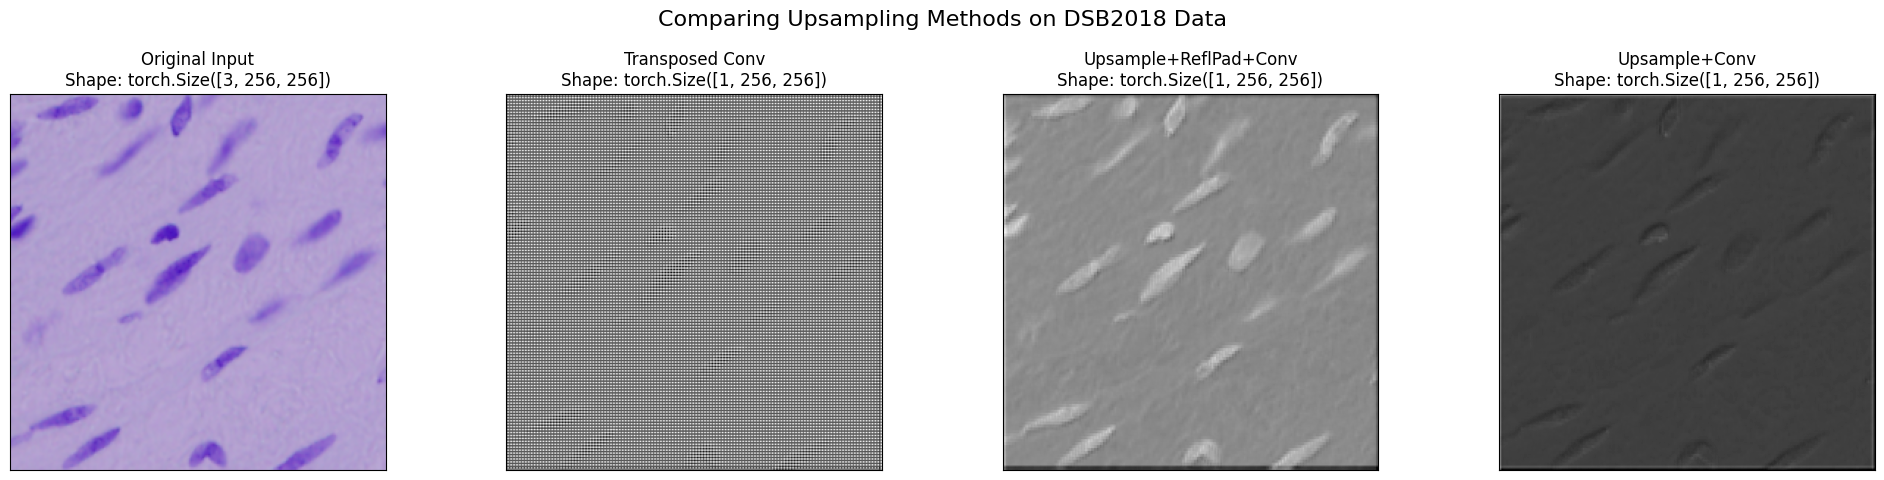

In [8]:
if __name__ == '__main__' and train_seg_loader:
    # A simple encoder to downsample the image first
    encoder = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2) # 256x256 -> 128x128
    ).to(device)

    # --- Instantiate the three upsampling methods ---
    # Kernel size 2, stride 2 is a classic recipe for checkerboarding
    transposed_conv = nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2).to(device)
    
    # Our custom classes
    upsample_conv_pad = Conv2dExpansionWithPad(32, 1, kernel_size=3).to(device)
    upsample_conv_nopad = Conv2dExpansionNoPad(32, 1, kernel_size=3).to(device)
    
    # Get a batch of images
    images, _ = next(iter(train_seg_loader))
    images = images.to(device)
    
    # Get the outputs from all methods
    with torch.no_grad():
        encoded_images = encoder(images)
        output_t_conv = transposed_conv(encoded_images)
        output_up_pad = upsample_conv_pad(encoded_images)
        output_up_nopad = upsample_conv_nopad(encoded_images)

    # Visualize the first image from the batch
    plot_outputs(
        images[0],
        output_t_conv[0],
        output_up_pad[0],
        output_up_nopad[0]
    )


Dataset already exists.


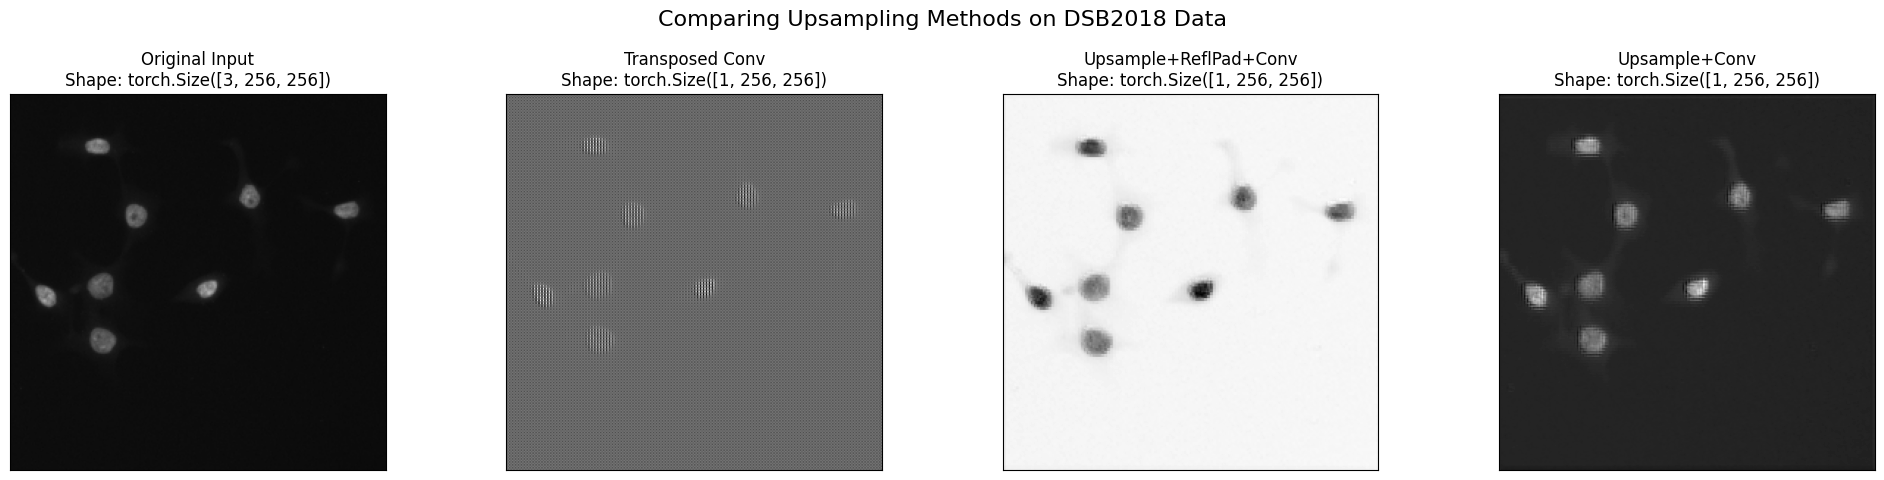

In [1]:
if __name__ == '__main__' and train_seg_loader:
    # A simple encoder to downsample the image first
    encoder = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2) # 256x256 -> 128x128
    ).to(device)

    # --- Instantiate the three upsampling methods ---
    # Kernel size 2, stride 2 is a classic recipe for checkerboarding
    transposed_conv = nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2).to(device)
    
    # Our custom classes
    upsample_conv_pad = Conv2dExpansionWithPad(32, 1, kernel_size=3).to(device)
    upsample_conv_nopad = Conv2dExpansionNoPad(32, 1, kernel_size=3).to(device)
    
    # Get a batch of images
    images, _ = next(iter(train_seg_loader))
    images = images.to(device)
    
    # Get the outputs from all methods
    with torch.no_grad():
        encoded_images = encoder(images)
        output_t_conv = transposed_conv(encoded_images)
        output_up_pad = upsample_conv_pad(encoded_images)
        output_up_nopad = upsample_conv_nopad(encoded_images)

    # Visualize the first image from the batch
    plot_outputs(
        images[0],
        output_t_conv[0],
        output_up_pad[0],
        output_up_nopad[0]
    )
